<a href="https://colab.research.google.com/github/benduong2001/dsproject_font_decorator/blob/main/dsproject_font_decorator_kaggle.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import sklearn.decomposition
import pandas as pd
import os
from PIL import Image
from sklearn.preprocessing import normalize

plt.rcParams['figure.figsize'] = (7,7)

In [2]:
import sklearn.neighbors
import sklearn.manifold
from sklearn.cluster import KMeans

from tqdm import tqdm

In [4]:
# Load the Drive helper and mount
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [6]:
PATH_FOLDER = "/content/drive/MyDrive/dsprojects/dsproject_imagery/dsprojects_fonts/"
font_folder_path = PATH_FOLDER + "/fonts/"
uci_font_family_csv_file_names = os.listdir(font_folder_path) # list of file_names. Each file is the csv for a specific font

In [76]:
# for each font's csv table, the column "m_label" denotes an identifier for a certain character
# the variables below are the m_labels for specific character groups (alphanumeric - uppercase, lowercase, digits)
MIN_M_LABEL = 33
MAX_M_LABEL = 126
m_labels_all = list(range(MIN_M_LABEL,MAX_M_LABEL+1))
m_labels_alphanum_alpha_upper = list(range(m_labels_all[32], m_labels_all[32+26]))
m_labels_alphanum_alpha_lower = list(range(m_labels_all[64], m_labels_all[64+26]))
m_labels_alphanum_num = list(range(m_labels_all[16], m_labels_all[16+10]))

# each row of the csv table has a 20x20 image for the character it represents, which can be made using a group of 400 columns. These column names are collected here for future use
pixel_column_names = []
for i in range(0, 20):
    for j in range(0, 20):
        pixel_column_name = "r{0}c{1}".format(str(i),str(j))
        pixel_column_names.append(pixel_column_name)

# for this unsupervised classification, I'm going to just use the 26 capital letters to represent each font
# My main reason is that capital letters are arguably square-shaped and thus proportionally consistent in anatomy for most fonts.
# Because in this dataset, thin or wide characters get forcibly stretched or narrowed to fit a 20x20 space. 
# But you can change which characters you want to use below. 
CHOSEN_M_LABELS = []
CHOSEN_M_LABELS += m_labels_alphanum_alpha_upper
#CHOSEN_M_LABELS += m_labels_alphanum_alpha_lower
#CHOSEN_M_LABELS += m_labels_alphanum_num


CHARACTERS_AMOUNT = len(CHOSEN_M_LABELS)
# I'm going to iterate through each font file
# 
unraveled_unsupervised = []
font_visualizations = []
passed_font_families = []
failed_font_families = []

range_len_uci_font_family_csv_file_names = range(len(uci_font_family_csv_file_names))
range_len_uci_font_family_csv_file_names = tqdm(range_len_uci_font_family_csv_file_names)

for i in range_len_uci_font_family_csv_file_names:
    #if (((i+1)%25)==0): print(i+1, len(uci_font_family_csv_file_names));
    uci_font_family_csv_file_name = uci_font_family_csv_file_names[i]
    uci_font_family = uci_font_family_csv_file_name.split(".csv")[0]
    temp_uci_font_family_df_orig = pd.read_csv(font_folder_path + uci_font_family_csv_file_name)

    
    temp_uci_font_family_df_orig = temp_uci_font_family_df_orig[temp_uci_font_family_df_orig["m_label"].isin(CHOSEN_M_LABELS)] 
    # get the chosen labels 
    temp_uci_font_family_df_orig = temp_uci_font_family_df_orig.sort_values("m_label") 
    # make sure that the characters are in order, which is necessary for a horizontal concatenation and consistent embedding later on.
    temp_uci_font_family_df_orig = temp_uci_font_family_df_orig[temp_uci_font_family_df_orig["strength"] <= 0.5] 
    # remove bolded
    temp_uci_font_family_df_orig = temp_uci_font_family_df_orig[temp_uci_font_family_df_orig["italic"] <= 0.5] 
    # remove italicized
    temp_uci_font_family_df_orig = temp_uci_font_family_df_orig.drop_duplicates(subset=["m_label","strength","italic"]) 
    # remove any duplicates left over

    # CHARACTERS_AMOUNT is 26 if you are just doing uppercase letters

    try:
        assert temp_uci_font_family_df_orig.shape[0] == CHARACTERS_AMOUNT
        
        temp_uci_font_family_df_pixels = temp_uci_font_family_df_orig[pixel_column_names]
        # temp_uci_font_family_df_pixels.shape == (26, 400)
        # each row is a character, and is a vector in R^400, that can be reshaped as a 20x20 image.

        temp_uci_font_family_char_concat = temp_uci_font_family_df_pixels.values.reshape((20*20*CHARACTERS_AMOUNT,))
        # we reshape the font's whole 26x400 table to be a horizontal concatenation as a vector in R^ 20*20*26
        # in other words, each row is joined end-to-end 
        unraveled_unsupervised.append(temp_uci_font_family_char_concat)

        font_visualizations.append(temp_uci_font_family_char_concat.reshape(CHARACTERS_AMOUNT,20,20))
        # this gives back a list of 20x20 arrays that can be used for EDA visualization

        passed_font_families.append(uci_font_family)
    except Exception as e:
        #print(e)
        failed_font_families.append(uci_font_family)
        pass

100%|██████████| 153/153 [01:30<00:00,  1.69it/s]


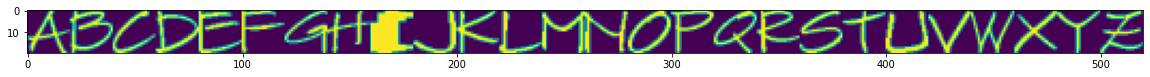

In [86]:
GIVEN_FONT = "SKETCHFLOW"

fig_temp, ax_temp = plt.subplots(figsize=(20,20))
given_font_index = passed_font_families.index(GIVEN_FONT)
plt.imshow(np.hstack(font_visualizations[given_font_index]))

In [43]:
eig_fonts_x = np.array(unraveled_unsupervised)#.shape

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_spectral_embedding.py:234: UserWarning: Array is not symmetric, and will be converted to symmetric by average with its transpose.
  adjacency = check_symmetric(adjacency)


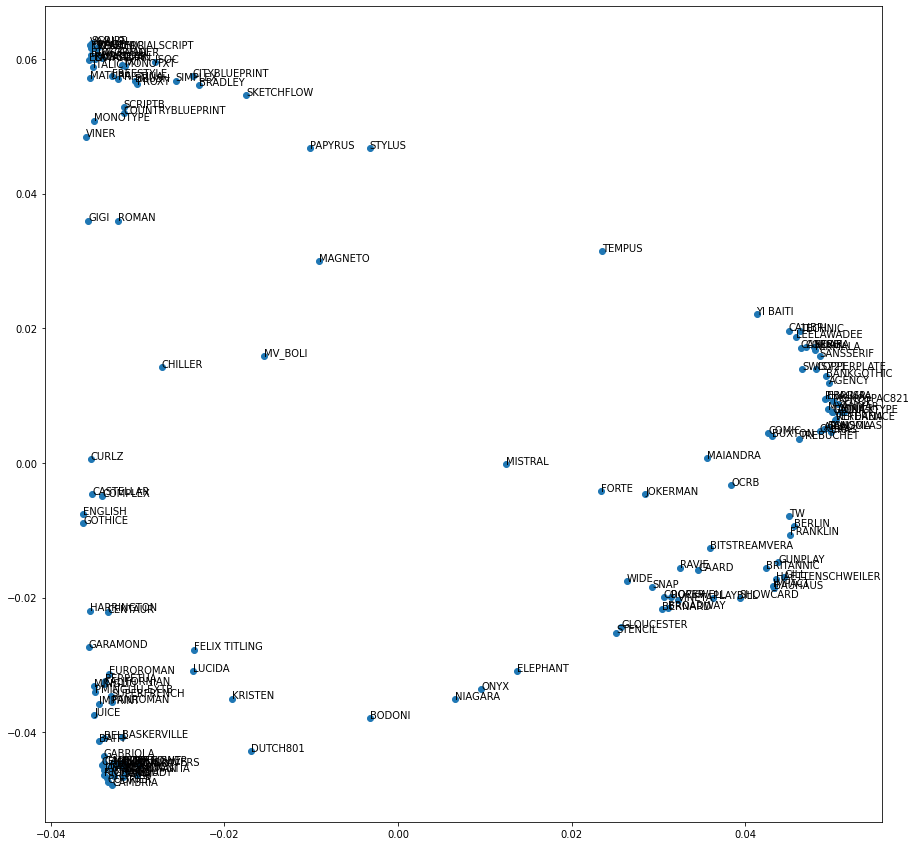

In [44]:
# eig_fonts_x.shape # is (147, 10400)
eig_fonts_x_normalized = normalize(eig_fonts_x, axis=1) #
#eig_fonts_cov = np.cov(eig_fonts_x_normalized) # 
eig_fonts_similarity_matrix = eig_fonts_x_normalized @ eig_fonts_x_normalized.T
W = eig_fonts_similarity_matrix

np.random.seed(1)
N_NEIGHBORS = 5
W = sklearn.neighbors.kneighbors_graph(eig_fonts_x, n_neighbors=N_NEIGHBORS)

N_EMBEDDINGS = 2
embedding = sklearn.manifold.spectral_embedding(W, n_components=N_EMBEDDINGS)

eigfont_embeddings_df = pd.DataFrame()
eigfont_embeddings_df["font"] = passed_font_families
embedding_column_names = []
for i in range(N_EMBEDDINGS):
    embedding_column_name = "embedding_{0}".format(i)
    embedding_column_names.append(embedding_column_name)
    eigfont_embeddings_df[embedding_column_name] = embedding[:,i]


# embedding.shape
x = embedding[:,0]
y = embedding[:,1]
n = passed_font_families
            
fig, ax = plt.subplots(1,1,figsize=(15,15))
ax.scatter(x, y)

for i, txt in enumerate(n):
    ax.annotate(txt, (x[i], y[i]))

* After the use of spectral embedding, we can clearly see some well defined clusters. 
  * Serifed Fonts like Garamond and Bookman are clumped on the bottom left.
  * San-Serifed Fonts are clumped on the right
  * Calligraphic Fonts are clumped on the top

* Next step is to use K-means Clustering on this embedding. Sensibly, with k = 3

In [47]:
N_CLUSTERS = 3
np.random.seed(1)

kmeans = KMeans(n_clusters=N_CLUSTERS, random_state=0).fit(eigfont_embeddings_df[embedding_column_names])
kmeans.labels_

eigfont_embeddings_df["cluster"] = kmeans.labels_



# Another thing we can do is to be less discrete with grouping the fonts. 
# Instead being binary, this part will ambiguously decide how each font can be grouped under each cluster group as a proportion, based on the distance to the cluster centroid

cluster_center_i_distance_column_names = []
for i in range(N_CLUSTERS):
    cluster_center_i = kmeans.cluster_centers_[i]

    cluster_center_i_distance = 0
    for j in range(N_EMBEDDINGS):
        cluster_center_i_distance += (eigfont_embeddings_df["embedding_{0}".format(j)] - cluster_center_i[j])**2
    cluster_center_i_distance_column_name = "cluster_center_{0}_distance".format(i)
    cluster_center_i_distance_column_names.append(cluster_center_i_distance_column_name)
    eigfont_embeddings_df[cluster_center_i_distance_column_name] = cluster_center_i_distance

eigfont_embeddings_df_cluster_center_i_distance = eigfont_embeddings_df[cluster_center_i_distance_column_names]
#((eigfont_embeddings_df_cluster_center_i_distance)*-1).add(eigfont_embeddings_df_cluster_center_i_distance.max(axis=1),axis="index")

#(0.5*(1-(normalize(eigfont_embeddings_df_cluster_center_i_distance, axis=1,norm="l1"))))#.sum(axis=1)
eigfont_embeddings_df_cluster_center_i_distance = 1/eigfont_embeddings_df_cluster_center_i_distance
eigfont_embeddings_df_cluster_center_i_proximity = normalize(eigfont_embeddings_df_cluster_center_i_distance,axis=1,norm="l1")
eigfont_embeddings_df[cluster_center_i_distance_column_names] = eigfont_embeddings_df_cluster_center_i_proximity
eigfont_embeddings_df = eigfont_embeddings_df.rename(columns=dict([("cluster_center_{0}_distance", "cluster_center_{0}_proximity") for i in range(N_CLUSTERS)]))

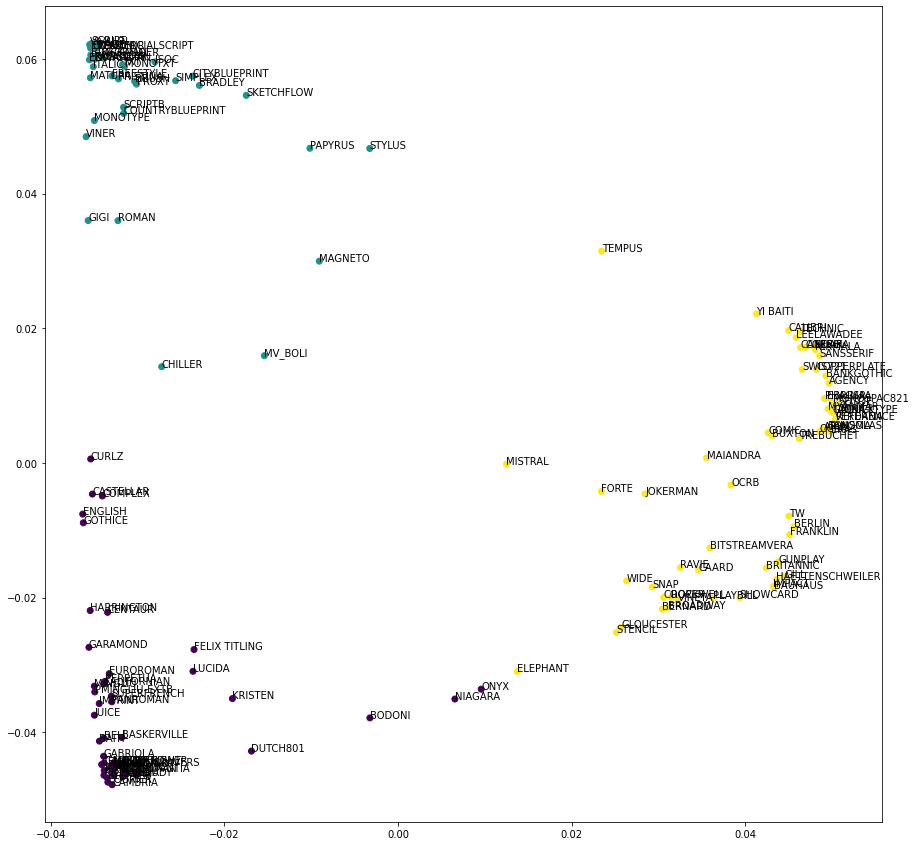

In [68]:
x = eigfont_embeddings_df["embedding_0"]
y = eigfont_embeddings_df["embedding_1"]
fonts = eigfont_embeddings_df["font"]
            
colors=eigfont_embeddings_df["cluster"]
#colors=((eigfont_embeddings_df_cluster_center_i_proximity)*255).astype(int)
fig, ax = plt.subplots(1,1,figsize=(15,15))
ax.scatter(x, y,c=colors)

for i, txt in enumerate(fonts):
    ax.annotate(txt, (x[i], y[i]))

In [83]:
eigfont_embeddings_df.head(11)

,font,embedding_0,embedding_1,cluster,cluster_center_0_distance,cluster_center_1_distance,cluster_center_2_distance
0,ARIAL,0.049071,0.005018,2,0.012299,0.011545,0.976156
1,AGENCY,0.049677,0.011838,2,0.026290,0.028586,0.945124
2,BODONI,-0.003243,-0.037879,0,0.770052,0.062242,0.167707
3,BAUHAUS,0.043358,-0.018579,2,0.049798,0.027209,0.922992
4,BERNARD,0.030437,-0.021743,2,0.116179,0.048975,0.834846
5,BRITANNIC,0.042435,-0.015583,2,0.034798,0.020008,0.945194
6,BOOK,-0.032336,-0.044897,0,0.980963,0.008240,0.010797
7,BERLIN,0.045644,-0.009442,2,0.013374,0.009030,0.977596
8,BOOKMAN,-0.031491,-0.045825,0,0.977850,0.009456,0.012694
9,BAITI,-0.034399,-0.041330,0,0.988982,0.004969,0.006049


In [ ]:
x_train = []
x_test = []
y_train = []
y_test = []

range_len_passed_font_families = range(len(passed_font_families))
range_len_passed_font_families = tqdm(range_len_passed_font_families)
for i in range_len_passed_font_families:
    passed_font_family = passed_font_families[i]
    #if (((i+1)%25)==0): print(i+1, len(passed_font_families));
    uci_font_family_csv_file_name = passed_font_family + ".csv"
    uci_font_family_csv_file_path = font_folder_path + uci_font_family_csv_file_name
    temp_uci_font_family_df_orig = pd.read_csv(uci_font_family_csv_file_path)
    temp_uci_font_family_df_orig = temp_uci_font_family_df_orig.sort_values("m_label")#.value_counts()
    temp_uci_font_family_df_orig = temp_uci_font_family_df_orig[temp_uci_font_family_df_orig["m_label"].isin(m_labels_alphanum_alpha_upper+m_labels_alphanum_alpha_lower+m_labels_alphanum_num)]
    temp_uci_font_family_df_orig = temp_uci_font_family_df_orig[temp_uci_font_family_df_orig["strength"] <= 0.5]
    temp_uci_font_family_df_orig = temp_uci_font_family_df_orig[temp_uci_font_family_df_orig["italic"] <= 0.5]
    temp_uci_font_family_df_orig = temp_uci_font_family_df_orig.drop_duplicates(subset=["m_label","strength","italic"])
    assert temp_uci_font_family_df_orig.shape[0] <= 26+26+50
    temp_uci_font_family_df_pixels = temp_uci_font_family_df_orig[pixel_column_names]

    train_test = np.random.choice([1,0],size=len(temp_uci_font_family_df_pixels), p=[0.75, 0.25])
    train_character_pics_flattened= temp_uci_font_family_df_pixels[train_test.astype(bool)]
    train_character_pics_reshaped = train_character_pics_flattened.values.reshape(train_character_pics_flattened.shape[0],20,20)

    train_ohe = eigfont_embeddings_df[eigfont_embeddings_df["font"]==passed_font_family][cluster_center_i_distance_column_names].values
    train_ohes = np.tile(train_ohe[0],(train_character_pics_flattened.shape[0],1))

    test_character_pics_flattened= temp_uci_font_family_df_pixels[~train_test.astype(bool)]
    test_character_pics_reshaped = test_character_pics_flattened.values.reshape(test_character_pics_flattened.shape[0],20,20)

    test_ohe = eigfont_embeddings_df[eigfont_embeddings_df["font"]==passed_font_family][cluster_center_i_distance_column_names].values
    test_ohes = np.tile(test_ohe[0],(test_character_pics_flattened.shape[0],1))


    x_train += list(train_character_pics_reshaped)
    y_train += list(train_ohes)
    x_test += list(test_character_pics_reshaped)
    y_test += list(test_ohes)

    #unraveled_unsupervised.append(temp_uci_font_family_char_concat)

In [52]:
LOSS_FUNCTION = 'sparse_categorical_crossentropy'; 
y_train = np.argmax(np.array(y_train),axis=1)

In [53]:
N_CLASSES = N_CLUSTERS

In [54]:
import tensorflow as tf
from keras.optimizers import adam_v2

In [55]:
#model = tf.keras.Sequential()
#model.add(tf.keras.layers.Conv2D(3, (2, 2), activation='relu', padding="same",input_shape=(20, 20, 1)))
#model.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2), strides=2))
#model.add(tf.keras.layers.Flatten())
#model.add(tf.keras.layers.Dense(N_CLASSES, activation=tf.nn.softmax))
#model.compile(optimizer=adam_v2.Adam(),loss=LOSS_FUNCTION)

In [56]:
def middle_fcn_layer_function(filters, kernel_size, strides, dropout_rate,x):
    x = tf.keras.layers.Conv2D(filters=filters, 
                               kernel_size=kernel_size, 
                               strides=strides,
                               padding="same")(x) 
    x = tf.keras.layers.Dropout(dropout_rate)(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Activation('relu')(x)
    return x

len_classes=N_CLASSES
dropout_rate=0.2

input_layer = tf.keras.layers.Input(shape=(None, None, 1)) # maybe change shape to just None, None if grayscale
## Middle FCN Layer

x = middle_fcn_layer_function(filters=5, kernel_size=3, strides=1, dropout_rate=dropout_rate, x=input_layer)
x = middle_fcn_layer_function(filters=10, kernel_size=3, strides=1, dropout_rate=dropout_rate, x=x)
## take account of kernel size= 3 isfilter size not != RGB
## should it be bigger?

x = middle_fcn_layer_function(filters=20, kernel_size=3, strides=2, dropout_rate=dropout_rate, x=x)
#x = middle_fcn_layer_function(filters=256, kernel_size=3, strides=2, dropout_rate=dropout_rate, x=x)
#x = middle_fcn_layer_function(filters=512, kernel_size=3, strides=2, dropout_rate=dropout_rate, x=x)

x = middle_fcn_layer_function(filters=10, kernel_size=1, strides=1, dropout_rate=dropout_rate, x=x)
## penult layer

## Last FCN Layer
x = tf.keras.layers.Conv2D(filters=len_classes, kernel_size=1, strides=1)(x)
x = tf.keras.layers.Dropout(dropout_rate)(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.GlobalMaxPooling2D()(x)
predictions = tf.keras.layers.Activation('softmax')(x)
model = tf.keras.Model(inputs=input_layer, outputs=predictions)
## This is functional API
## https://keras.io/guides/functional_api/
model.compile(optimizer=tf.optimizers.Adam(),loss=LOSS_FUNCTION,metrics=['accuracy'])

In [57]:
model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, None, None, 1)]   0         
                                                                 
 conv2d_5 (Conv2D)           (None, None, None, 5)     50        
                                                                 
 dropout_5 (Dropout)         (None, None, None, 5)     0         
                                                                 
 batch_normalization_5 (Batc  (None, None, None, 5)    20        
 hNormalization)                                                 
                                                                 
 activation_5 (Activation)   (None, None, None, 5)     0         
                                                                 
 conv2d_6 (Conv2D)           (None, None, None, 10)    460       
                                                           

In [58]:
model.fit(np.array(x_train), (y_train), epochs = 20)

Epoch 1/20
215/215 [==============================] - 19s 80ms/step - loss: 1.0151 - accuracy: 0.5054
Epoch 2/20
215/215 [==============================] - 17s 79ms/step - loss: 0.8712 - accuracy: 0.6077
Epoch 3/20
215/215 [==============================] - 17s 78ms/step - loss: 0.8608 - accuracy: 0.6141
Epoch 4/20
215/215 [==============================] - 17s 78ms/step - loss: 0.8272 - accuracy: 0.6294
Epoch 5/20
215/215 [==============================] - 17s 78ms/step - loss: 0.8210 - accuracy: 0.6367
Epoch 6/20
215/215 [==============================] - 17s 77ms/step - loss: 0.7978 - accuracy: 0.6618
Epoch 7/20
215/215 [==============================] - 16s 77ms/step - loss: 0.7755 - accuracy: 0.6767
Epoch 8/20
215/215 [==============================] - 17s 77ms/step - loss: 0.7567 - accuracy: 0.6835
Epoch 9/20
215/215 [==============================] - 17s 78ms/step - loss: 0.7410 - accuracy: 0.6989
Epoch 10/20
215/215 [==============================] - 17s 79ms/step - loss: 0.733

In [87]:
((np.argmax(model.predict(np.array(x_test)),axis=1))==(np.argmax(y_test,axis=1))).mean()

0.7400447427293065

In [88]:
PATH_FOLDER = "/content/drive/MyDrive/dsprojects/dsproject_imagery/dsprojects_fonts/"
MODEL_FILE_PATH = PATH_FOLDER + "/versatile_font_embedding_cluster_classifier_cnn1.h5"
model.save(MODEL_FILE_PATH)

# START FROM HERE

# ORIG MODEL IS PATH_FOLDER + "/versatile_font_embedding_cluster_classifier_cnn.h5"
# KNEIGHBOR MODEL IS PATH_FOLDER + "/versatile_font_kn_embedding_cluster_classifier_cnn.h5"

from tensorflow import keras
model1 = keras.models.load_model(MODEL_FILE_PATH)

In [62]:
import matplotlib.pyplot as plt

In [63]:
import cv2
import urllib.request
import numpy as np
url = "https://external-content.duckduckgo.com/iu/?u=https%3A%2F%2Fwallup.net%2Fwp-content%2Fuploads%2F2016%2F03%2F10%2F343179-landscape-nature.jpg"
url = "https://mha.mun.ca/mha/cw/images/margins/scanned_letters/second-letter001.jpg"
#url = "https://upload.wikimedia.org/wikipedia/commons/f/f5/Spencerian_example.jpg"
url = "https://www2.wheaton.edu/bgc/archives/images/CNs/285/285-027-014/005.jpg"
url = "https://media.defense.gov/2016/Jan/21/2001336426/-1/-1/0/160121-F-HF287-001.JPG"
#url = "https://static.wikia.nocookie.net/logopedia/images/c/c0/DotCom_Logo_OnWhite.jpg/revision/latest?cb=20131114030000"
url_response = urllib.request.urlopen(url)
img = cv2.imdecode(np.array(bytearray(url_response.read()), dtype=np.uint8),-1)
img = img[:,:,::-1]

758


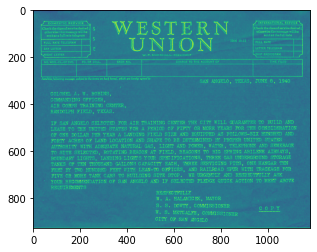

In [64]:
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
img = gray
plt.imshow(255-img)
img = 255-img

cv2.threshold(img,0,255,cv2.THRESH_BINARY+cv2.THRESH_OTSU,img)
#ret, thresh1 = cv2.threshold(gray, 0, 255, cv2.THRESH_OTSU | cv2.THRESH_BINARY_INV)

#th3 = cv2.adaptiveThreshold(img,255,cv2.ADAPTIVE_THRESH_GAUSSIAN_C,cv2.THRESH_BINARY,11,2)
find_contours_output = cv2.findContours(img, cv2.RETR_EXTERNAL,cv2.CHAIN_APPROX_NONE)
#print((find_contours_output[0]))

contours = find_contours_output[0]
hier =  find_contours_output[1]
print(len(contours))

In [65]:
contour_i = 400

189 549 12 15
(14, 11)


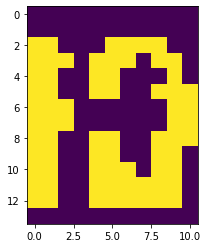

In [66]:
x, y, w, h = cv2.boundingRect(contours[contour_i])
print(x, y, w, h)
cnt = contours[contour_i]
rect = cv2.minAreaRect(cnt)
box = cv2.boxPoints(rect)
box = np.int0(box)

max_x = np.max(box[:,0])
min_x = np.min(box[:,0])
max_y = np.max(box[:,1])
min_y = np.min(box[:,1])

extraction = img[min_y:max_y,min_x:max_x]
print(extraction.shape)
plt.imshow(255-img[min_y:max_y,min_x:max_x])

In [67]:
model1.predict(np.array([extraction]))

array([[0.8200281 , 0.10781529, 0.07215656]], dtype=float32)

In [74]:
predictions = []
range_len_contours = range(len(contours))
range_len_contours = tqdm(range_len_contours)
for contour_i in range_len_contours:
    #if (((contour_i+1)%100)==0): print(contour_i+1, (len(contours)));
    try:
        x, y, w, h = cv2.boundingRect(contours[contour_i])
        cnt = contours[contour_i]
        rect = cv2.minAreaRect(cnt)
        box = cv2.boxPoints(rect)
        box = np.int0(box)

        max_x = np.max(box[:,0])
        min_x = np.min(box[:,0])
        max_y = np.max(box[:,1])
        min_y = np.min(box[:,1])

        extraction = img[min_y:max_y,min_x:max_x]
        prediction = model1.predict(np.array([extraction]))[0]
        predictions.append(prediction)
    except:
        pass
segmented_character_font_embedding_cluster_classification_predictions = predictions

100%|██████████| 758/758 [01:12<00:00, 10.51it/s]


In [75]:
np.nan_to_num(np.array(segmented_character_font_embedding_cluster_classification_predictions)).sum(axis=0)# = predictions

array([451.372  , 117.28547, 149.34245], dtype=float32)